<a href="https://colab.research.google.com/github/tomPlus353/google-colab-notebooks/blob/main/house_price_neural_net(kaggle).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title no. 1 setup project

Notes of progress

Date: 2025/11/17
Model: neural net
Params: MAE,Adam,Rele | Limted numer of cols | 0.2 dropoff | 3 layers|
Change from previous: n/a
Result: MAE as % of mean = 16% | R2 = 0.52

Date: 2025/11/17
Model: neural net
Params: MAE,Adam,Rele | Limted numer of cols | 0.2 dropoff | 3 layers |
Change from previous: Increase number of numeric features
Result: MAE as % of mean = 17% | R2 = 0.55

Date: 2025/11/17
Model: neural net
Params: MAE,Adam,Rele | Limted numer of cols | 0.2 dropoff | 3 layers |
Change from previous: use robust scaler instead of standard scaler
Result: MAE as % of mean = 17% | R2 = 0.57

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nishiodens/japan-real-estate-transaction-prices")

print("Path to dataset files:", path)

100%|██████████| 97.3M/97.3M [00:01<00:00, 76.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nishiodens/japan-real-estate-transaction-prices/versions/1


In [3]:
#path from previous download
# path = "/root/.cache/kagglehub/datasets/nishiodens/japan-real-estate-transaction-prices/versions/1"

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd ..
%ls

Mounted at /gdrive
/
bin@                        home/    NGC-DL-CONTAINER-LICENSE  srv/
boot/                       kaggle/  opt/                      sys/
content/                    lib@     proc/                     tmp/
cuda-keyring_1.1-1_all.deb  lib32@   python-apt/               tools/
datalab/                    lib64@   python-apt.tar.xz*        usr/
dev/                        libx32@  root/                     var/
etc/                        media/   run/
gdrive/                     mnt/     sbin@


In [5]:
%cd $path
%ls

/root/.cache/kagglehub/datasets/nishiodens/japan-real-estate-transaction-prices/versions/1
prefecture_code.csv  trade_prices/


In [6]:
!pip install tensorflow

In [7]:
#@title no. 2 build and save model

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# load data
# Adding low_memory=False to help pandas infer types correctly from mixed columns
with open(f"{path}/trade_prices/04.csv") as f:
    data = pd.read_csv(f, low_memory=False)


# All cols

all_cols = ['Region', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'Area',
       'AreaIsGreaterFlag',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear',
       'Structure', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Year', 'Quarter'
       ]

# select categorical and numerical features by data types
num_cols = []
target_exposed_cols = [
    'TradePrice',
]
for col in all_cols:
    if col in data.columns and pd.api.types.is_numeric_dtype(data[col]) and not col in target_exposed_cols:
        num_cols.append(col)

cat_cols = []
for col in all_cols:
    if col in data.columns and pd.api.types.is_object_dtype(data[col]):
        cat_cols.append(col)

print("String columns from 'all_cols' list:")
print(cat_cols)


# only target houses
data = data[data["Type"] == "Residential Land(Land and Building)"]

# Convert all specified numerical columns to numeric, coercing errors to NaN
# This ensures that these columns are properly numerical before calculating means.
for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing numerical values with the mean of their respective columns
for col in num_cols:
    if data[col].isnull().any(): # Check if there are any NaNs to fill
        data[col] = data[col].fillna(data[col].mean())

# Fill missing categorical values with the mode of their respective columns
for col in cat_cols:
    if data[col].isnull().any(): # Check if there are any NaNs to fill
        mode_val = data[col].mode()
        if not mode_val.empty:
            data[col] = data[col].fillna(mode_val[0])
        else:
            # If mode is empty (e.g., all NaNs), fill with a placeholder string
            data[col] = data[col].fillna('Unknown')

# For any other object-type columns not in cat_cols, fill with 'Unknown'
# This handles other categorical columns that might have NaNs but are not part of cat_cols
for col in data.select_dtypes(include='object').columns:
    if col not in cat_cols and data[col].isnull().any():
        data[col] = data[col].fillna('Unknown')

# For any other numeric-type columns not in num_cols, fill with their mean
# This handles other numeric columns that might have NaNs but are not part of num_cols
for col in data.select_dtypes(include=np.number).columns:
    if col not in num_cols and data[col].isnull().any():
        data[col] = data[col].fillna(data[col].mean())


# # drop nan values
# data.dropna(subset=num_cols, inplace=True)

String columns from 'all_cols' list:
['Region', 'Structure', 'Purpose', 'Direction', 'Classification', 'CityPlanning']


In [9]:

# check the data type of each column
print(data[num_cols + cat_cols].dtypes)
print(data[num_cols + cat_cols].describe)

data[num_cols + cat_cols].head()


MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
Area                             int64
AreaIsGreaterFlag                int64
Frontage                       float64
FrontageIsGreaterFlag             bool
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
Breadth                        float64
CoverageRatio                  float64
FloorAreaRatio                 float64
Year                             int64
Quarter                          int64
Region                          object
Structure                       object
Purpose                         object
Direction                       object
Classification                  object
CityPlanning                    object
dtype: object
<bound method NDFrame.describe of        MinTimeToNearestStation  MaxTimeToNearestStation  Area  \
2                          8.0                      8.0   230   
9                          8.0            

,MinTimeToNearestStation,MaxTimeToNearestStation,Area,AreaIsGreaterFlag,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter,Region,Structure,Purpose,Direction,Classification,CityPlanning
2,8.0,8.0,230,0,15.0,False,105.0,0,1997.507114,4.0,60.0,200.0,2018,1,Residential Area,LS,House,North,City Road,Category II Residential Zone
9,8.0,8.0,200,0,16.0,False,175.0,0,2015.000000,4.5,60.0,200.0,2015,1,Residential Area,W,House,Northwest,Private Road,Category II Residential Zone
11,30.0,60.0,450,0,25.5,False,115.0,0,1993.000000,6.0,40.0,60.0,2019,2,Residential Area,LS,House,West,City Road,Category I Exclusively Low-story Residential Zone
13,30.0,60.0,230,0,13.5,False,65.0,0,1994.000000,16.0,60.0,200.0,2019,1,Residential Area,W,House,Northeast,City Road,Category I Residential Zone
15,30.0,60.0,290,0,15.0,False,190.0,0,1994.000000,16.0,60.0,200.0,2018,3,Residential Area,W,House,Southeast,City Road,Category I Residential Zone


                             MinTimeToNearestStation  MaxTimeToNearestStation  \
MinTimeToNearestStation                     1.000000                 0.648648   
MaxTimeToNearestStation                     0.648648                 1.000000   
Area                                        0.133151                 0.057138   
AreaIsGreaterFlag                           0.057064                 0.034000   
Frontage                                    0.147506                 0.093223   
FrontageIsGreaterFlag                       0.053571                 0.032449   
TotalFloorArea                             -0.061568                -0.081506   
TotalFloorAreaIsGreaterFlag                -0.024716                -0.030481   
BuildingYear                               -0.055991                -0.020527   
Breadth                                    -0.009720                 0.001659   
CoverageRatio                              -0.221981                -0.394145   
FloorAreaRatio              

<Figure size 640x480 with 0 Axes>

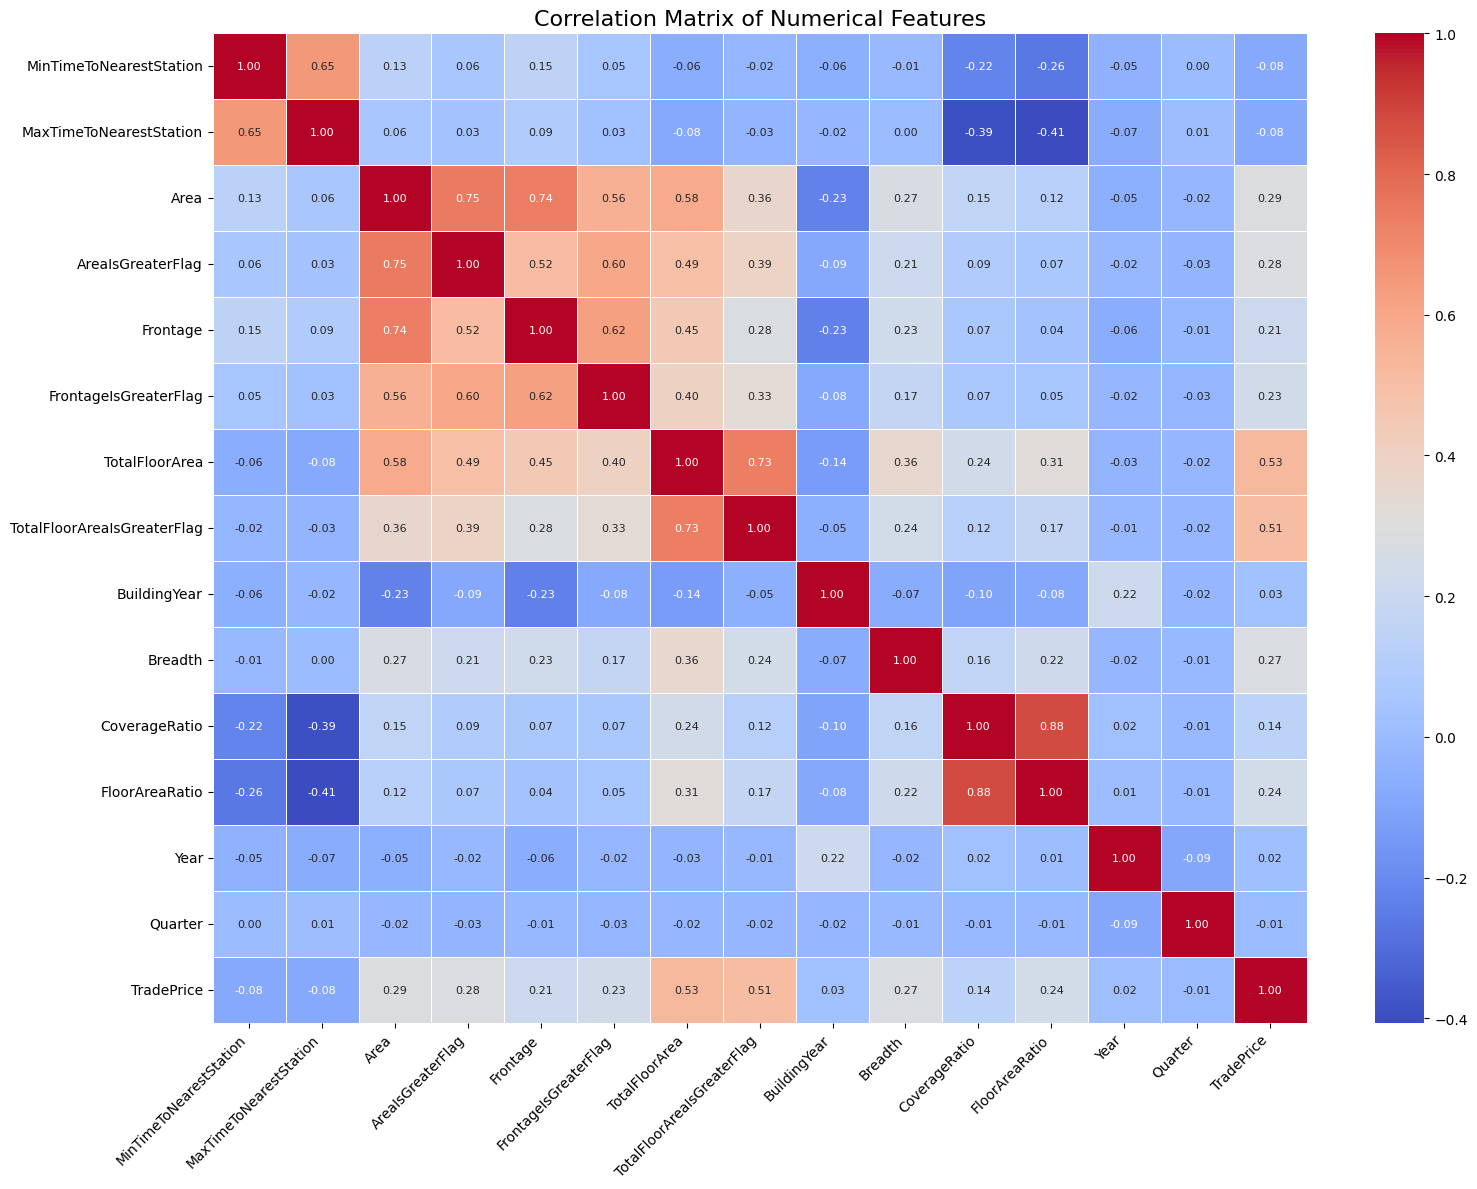

['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area', 'AreaIsGreaterFlag', 'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea', 'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'Breadth', 'CoverageRatio', 'FloorAreaRatio', 'Year', 'Quarter']


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def showCorrelation(df, columns, target):
  # Clear the current figure to ensure a fresh plot
  plt.clf()
  # Create a figure with a significantly larger size
  plt.figure(figsize=(16, 12)) # Increased size

  num_cols_with_target = columns.copy()
  num_cols_with_target.append(target)

  # calculate the correlation matrix for the selected columns
  corr_matrix = df[num_cols_with_target].corr()

  # print the correlation matrix
  print(corr_matrix)

  # visualize the correlation matrix using a heatmap
  sns.heatmap(corr_matrix,
              cmap='coolwarm',
              annot=True,
              fmt=".2f",
              linewidths=.5,
              annot_kws={"size": 8}) # Set annotation font size
  plt.title('Correlation Matrix of Numerical Features', fontsize=16) # Add a title for clarity
  plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate x-axis labels for better readability and set font size
  plt.yticks(rotation=0, fontsize=10) # Ensure y-axis labels are horizontal and set font size
  plt.tight_layout() # Adjust layout to prevent labels from being cut off
  plt.show() # Display the plot

showCorrelation(data, num_cols,'TradePrice')
print(num_cols)

### Plotting Categorical Features vs. TradePrice

I will generate box plots for each categorical feature against the `TradePrice` to observe their influence. This helps in understanding how the distribution of `TradePrice` varies across different categories.

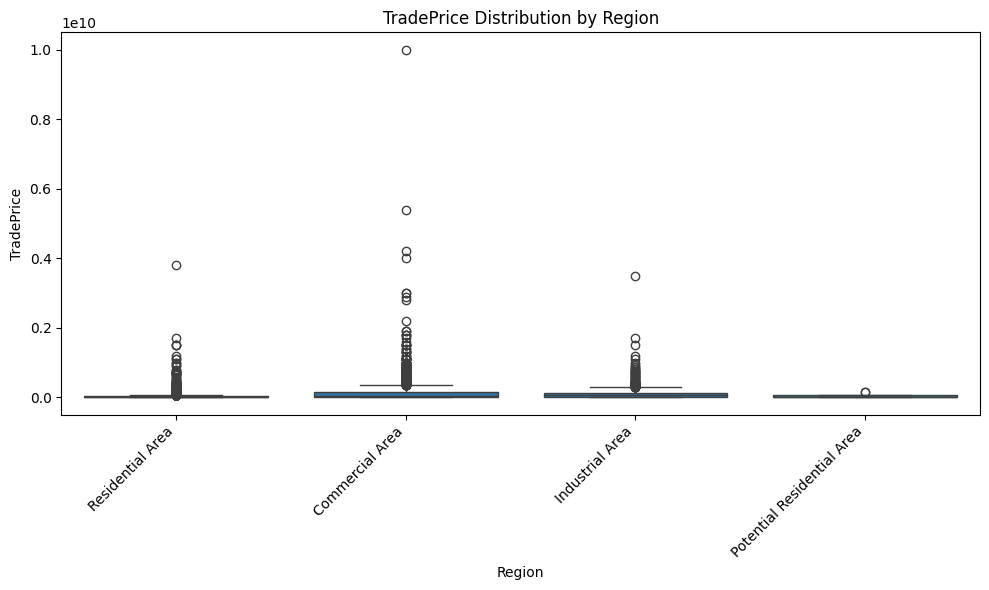

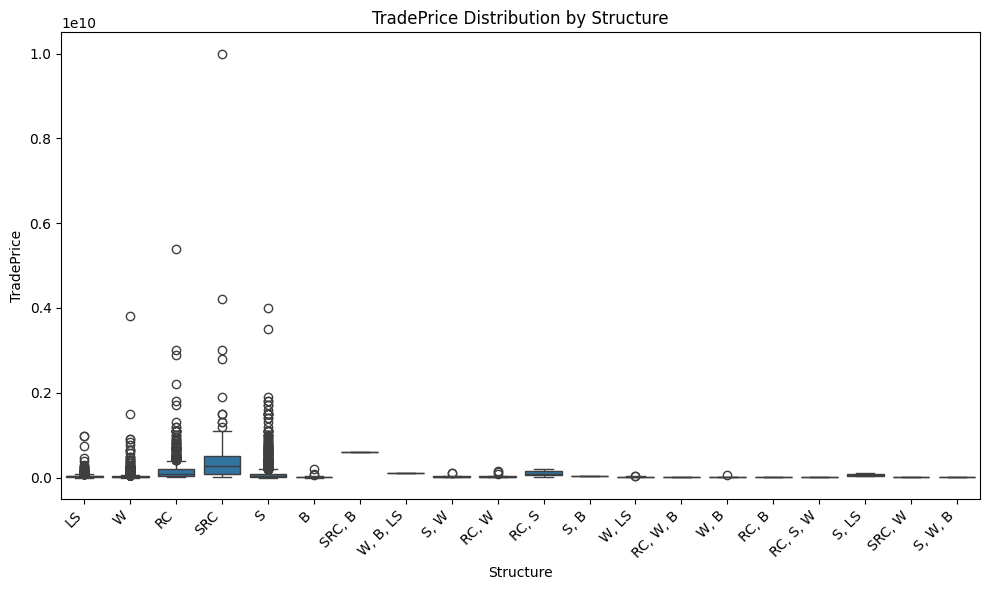

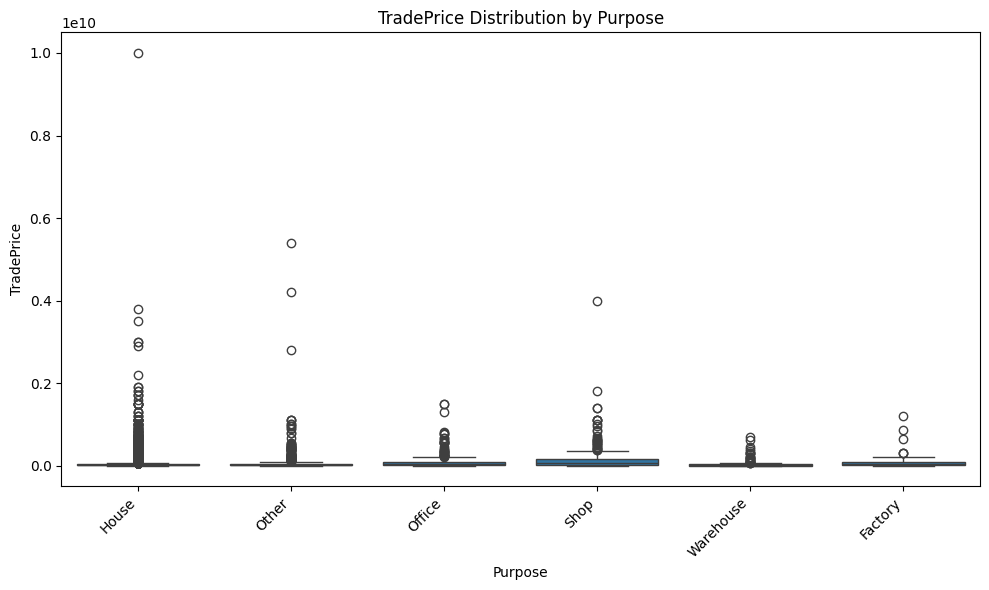

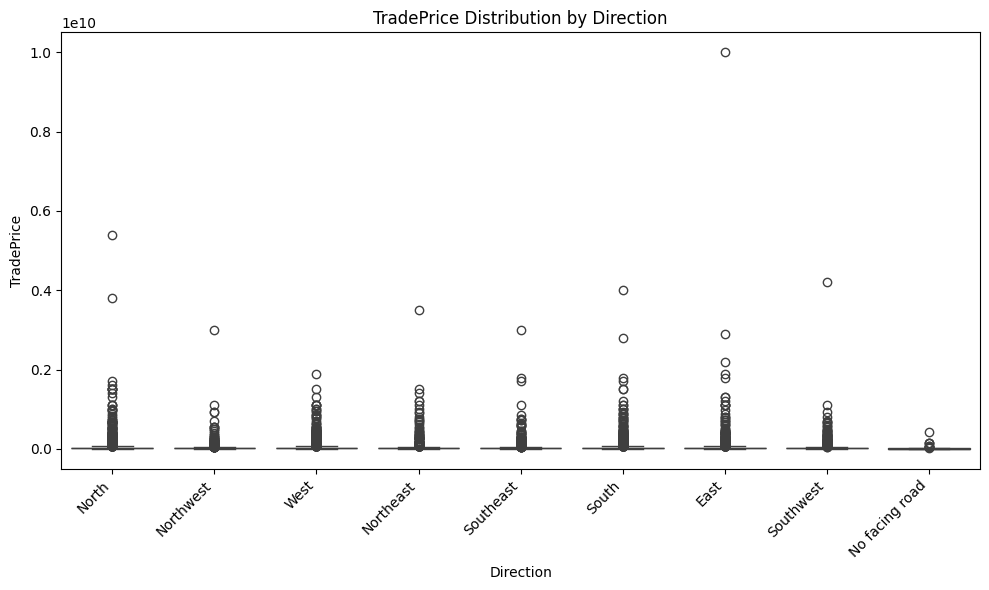

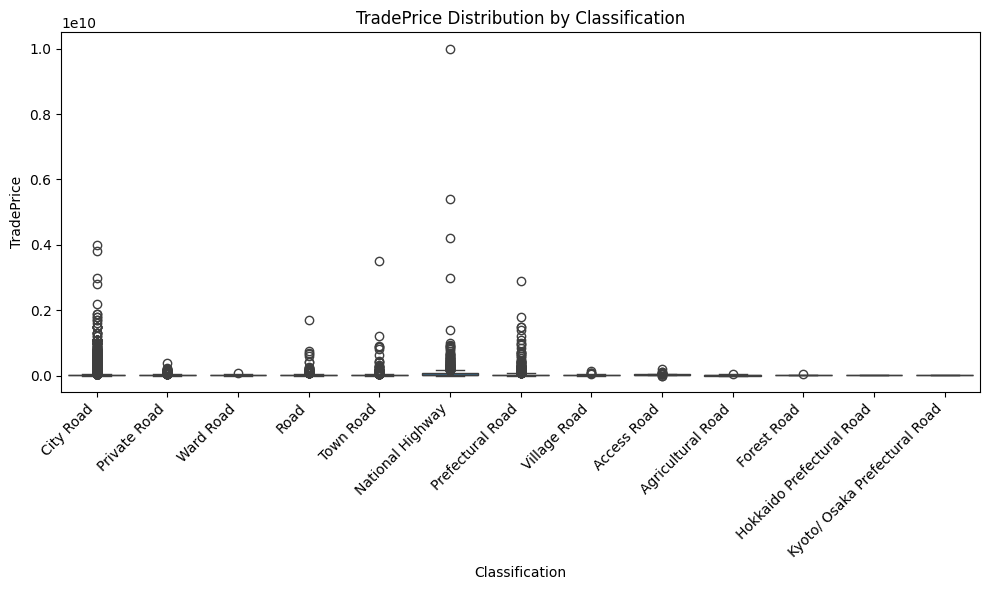

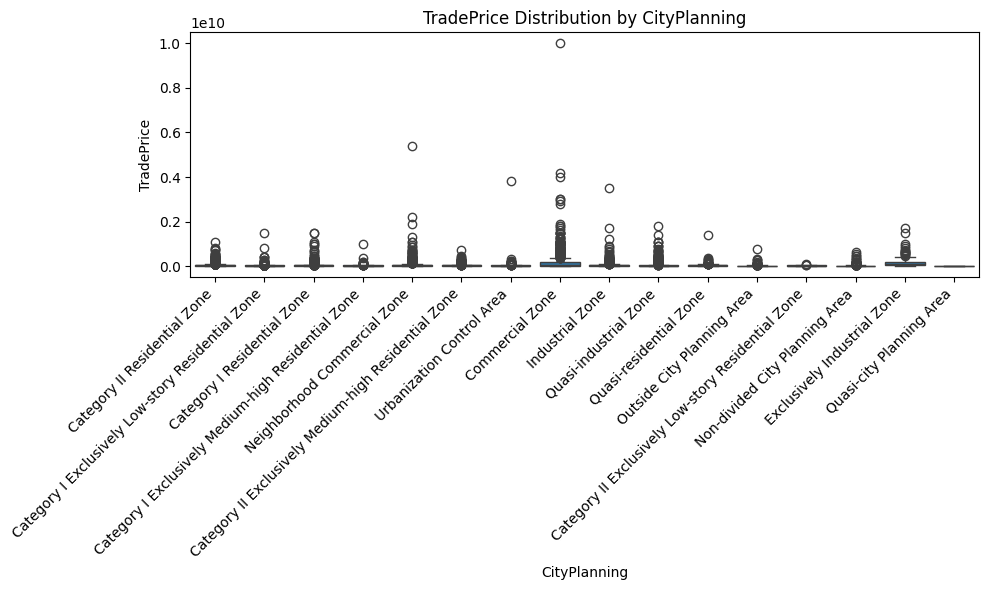

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'TradePrice' is numeric
data['TradePrice'] = pd.to_numeric(data['TradePrice'], errors='coerce')

# Drop rows where 'TradePrice' might be NaN after coercion
data_cleaned = data.dropna(subset=['TradePrice'])

# Iterate through each categorical column and create a box plot
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='TradePrice', data=data_cleaned)
    plt.title(f'TradePrice Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('TradePrice')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [12]:
# for col in data.columns:
#     print(f"Unique values for column {col}:")
#     print(len(data[col].unique()))

In [13]:
## created new unique location including district and municipality
data['DistrictName2'] = data['DistrictName'].astype('str') + data['Municipality'].astype('str')
cat_cols.append('DistrictName2')

In [14]:
# for col in data.columns:
#     print(f"Unique values for column {col}:")
#     print(len(data[col].unique()))

In [15]:
checkpoint_path = "gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [16]:
# one-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(data[cat_cols])
encoded_cat = encoder.transform(data[cat_cols]).toarray()

# standardize numerical features

scaler = RobustScaler()
scaled_num = scaler.fit_transform(data[num_cols])

# combine encoded categorical and scaled numerical features
X = np.hstack((encoded_cat, scaled_num))

# define target variable
y = data['TradePrice']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(23212, 1470)


In [17]:
# define model
model = Sequential()
model.add(Dense(units=int(X_train.shape[1] / 2), activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=int(X_train.shape[1] / 4), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=int(X_train.shape[1] / 8), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile model
model.compile(loss='mae', optimizer='adam')

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
with tf.device('/GPU:0'):  # Use the first GPU
  model.fit(X_train,
            y_train,
            epochs=100,
            validation_data=(X_test, y_test),
            callbacks=[early_stop, cp_callback]
            )

# evaluate model
mae = model.evaluate(X_test, y_test)
print(f"Mean absolute error: {mae:.2f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30541590.0000
Epoch 1: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5
726/726 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 30534700.0000 - val_loss: 18828532.0000
Epoch 2/100
704/726 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18472080.0000
Epoch 2: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5
726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18433208.0000 - val_loss: 16423397.0000
Epoch 3/100
713/726 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16261904.0000
Epoch 3: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5
726/726 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16262435.0000 - val_loss: 15926229.0000
Epoch 4/100
719/726 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15749781.0000
Epoch 4: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5
726/726 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 15751243.0000 - val_loss: 15559709.0000
Epoch 5/100
718/726

In [18]:
# plot_and_evaluate_cv
from sklearn.metrics import r2_score, median_absolute_error

#
y_pred = model.predict(X_test)


# Calculate Errors and Correlation
r2 = r2_score(y_test, y_pred)
mae = median_absolute_error(y_test, y_pred)
print(f"R-square (R2): {r2}")
print(f"Median absolute error: {mae}")


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R-square (R2): 0.5539498329162598
Median absolute error: 3823993.0


In [19]:
avg = y.median()
print(f"Mean absolute error as percentage of median price: {(mae/avg)*100}%")

Mean absolute error as percentage of median price: 16.62605652173913%


In [20]:
#@title Insert Test Field
"""
cat_cols = [
   'Municipality',
    'DistrictName',
    'DistrictName2',
    # 'Region',
    # 'NearestStation',
    # 'CityPlanning',
            ]

num_cols = [
            'Area',
            'TotalFloorArea',
            'BuildingYear',
            'CoverageRatio',
            'FloorAreaRatio',
            'MaxTimeToNearestStation',
            'MinTimeToNearestStation',
            # 'Year',
            # 'Quarter',
            # 'Breadth',
            # 'Frontage',
            ]
"""
import ipywidgets as widgets

import pandas as pd

# Get unique values in a column as a list
options_city = data['Municipality'].unique().tolist()
options_district = data['DistrictName'].unique().tolist()


# Create a dropdown widget with options
dropdown_city = widgets.Dropdown(
    options=options_city,
    description='city:',

    )
dropdown_district = widgets.Dropdown(
    options=options_district,
    description='district name:',
    )
float_area = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='plot area square meters:',
    disabled=False
)
float_floor_area = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='floor area square meters:',
    disabled=False,
)

float_building_year = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=2030.0,
    step=1.0,
    description='year built:',
    disabled=False
)
float_coverage_ratio = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='CoverageRatio:',
    disabled=False
)
float_floor_ratio = widgets.BoundedFloatText(
    value=None,
    min=10.0,
    max=1000.0,
    step=1.0,
    description='FloorAreaRatio:',
    disabled=False
)
float_maxTimeToNearestStation = widgets.BoundedFloatText(
    value=None,
    min=1.0,
    max=1000.0,
    step=1.0,
    description='max time to station:',
    disabled=False
)
float_minTimeToNearestStation = widgets.BoundedFloatText(
    value=None,
    min=1.0,
    max=1000.0,
    step=1.0,
    description='min time to station:',
    disabled=False
)
inputs = [
    dropdown_city,
    dropdown_district,
    float_area,
    float_floor_area,
    float_building_year,
    float_coverage_ratio,
    float_floor_ratio,
    float_maxTimeToNearestStation,
    float_minTimeToNearestStation,
]

# Display the dropdown widget
for i in inputs:
  label = widgets.Label(value=i.description)
  i.description = ""
  display(widgets.HBox([label, i]))

In [21]:

"""
Show result
"""
for i in inputs:
  print(f"The saved value is: {i.value}")



The saved value is: Aoba Ward,Sendai City
The saved value is: Aobamachi
The saved value is: 10.0
The saved value is: 10.0
The saved value is: 10.0
The saved value is: 10.0
The saved value is: 10.0
The saved value is: 1.0
The saved value is: 1.0


In [22]:
saved_user_test_case = {
    'Municipality': 'Izumi Ward,Sendai City',
    'DistrictName': 'Minaminakayama',
    'Area': 225.09,
    'TotalFloorArea': 129.89,
    'BuildingYear': 1996.0,
    'CoverageRatio': 40.0,
    'FloorAreaRatio': 60.0,
    'MaxTimeToNearestStation': 21.0,
    'MinTimeToNearestStation': 21.0
}

In [23]:
import pandas as pd
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# Check if widgets are defined. If not, inform the user.
# This error typically means the preceding cell (HjUXujsXgy1e) defining the widgets was not run.
if 'dropdown_city' not in globals():
    print("Error: Interactive widgets are not defined. Please run the cell 'HjUXujsXgy1e' (the 'Insert Test Field' cell) first to define the input widgets.")
    raise NameError("Interactive widgets not defined. Please run the widget definition cell.")

# Assuming `data`, `cat_cols`, `num_cols`, `encoder`, and `scaler`
# are available from previous cells and are correctly fitted/defined.
# X_train.shape[1] was 2743 based on the output of cell g5wOionxsAKc.
# input_dim_for_model = 2743

# Create dataframe from inputted values
userTestDictionary = {
      'Municipality': [dropdown_city.value], # Wrap in list to create a DataFrame with one row
      'DistrictName': [dropdown_district.value],
      'Area': [float_area.value],
      'TotalFloorArea': [float_floor_area.value],
      'BuildingYear': [float_building_year.value],
      'CoverageRatio': [float_coverage_ratio.value],
      'FloorAreaRatio': [float_floor_ratio.value],
      'MaxTimeToNearestStation':[float_maxTimeToNearestStation.value],
      'MinTimeToNearestStation':[float_minTimeToNearestStation.value],
}
userTest = pd.DataFrame(userTestDictionary)

# Add 'DistrictName2' to userTest, consistent with previous preprocessing
userTest['DistrictName2'] = userTest['DistrictName'].astype('str') + userTest['Municipality'].astype('str')

# One-hot encode categorical features using the *already fitted* encoder
# `cat_cols` should contain 'DistrictName2' as well, as updated in cell ImkHU6CrF9IF
encoded_cat_user = encoder.transform(userTest[cat_cols]).toarray()

# Standardize numerical features using the *already fitted* scaler
scaled_num_user = scaler.transform(userTest[num_cols])

# Combine encoded categorical and scaled numerical features
X_usertest = np.hstack((encoded_cat_user, scaled_num_user))

# # Define model with the *exact same architecture* as the trained model in fzJYCx88OO9k
# model = Sequential()
# model.add(Dense(units=input_dim_for_model / 2, activation='relu', input_shape=(input_dim_for_model,)))
# model.add(Dropout(0.5))
# model.add(Dense(units=input_dim_for_model / 4, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=input_dim_for_model / 8, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))

# # Compile model with the same loss as training
# model.compile(loss='mae', optimizer='adam') # Use 'mae' as in training

# # Load saved weights (using the corrected checkpoint_path from the previous fix)
# checkpoint_path = "gdrive/MyDrive/Colab_Notebooks/training_1/cp.weights.h5"
# model.load_weights(checkpoint_path)

# Make predictions
y_usertest = model.predict(X_usertest)
print(f"Predicted price: {y_usertest[0][0]:,.2f} JPY")

KeyError: "['Region', 'Structure', 'Purpose', 'Direction', 'Classification', 'CityPlanning'] not in index"